In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load RAVDESS Dataset
paths = []
labels = []
label_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
for dirname, _, filenames in os.walk('../RAVDESS_Audio_Speech_Actors_01-24'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('-')[2]
        label = label_map[label]
        labels.append(label.lower())
    if len(paths) == 2800:
        break

print(labels[:3])
print('Dataset is Loaded')

['neutral', 'neutral', 'neutral']
Dataset is Loaded


In [3]:
len(paths), len(labels)

(1440, 1440)

In [4]:
# Create a dataframe
ravdess = pd.DataFrame()
ravdess['speech'] = paths
ravdess['label'] = labels
ravdess.head()

,speech,label
0,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
1,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
2,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
3,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
4,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,calm


In [5]:
ravdess['label'].value_counts()

label
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

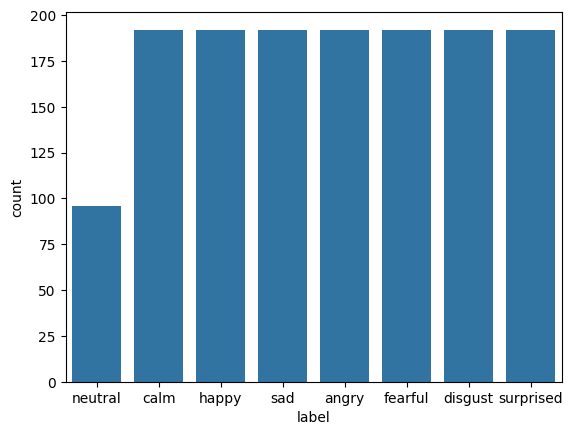

In [6]:
sns.countplot(data=ravdess, x='label')

In [7]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

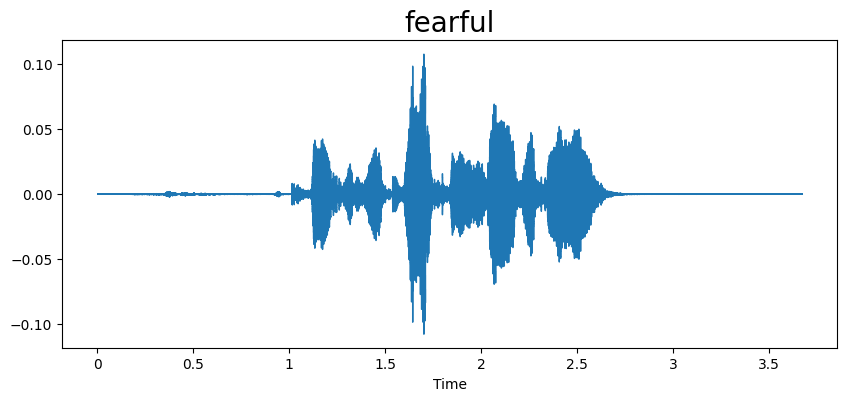

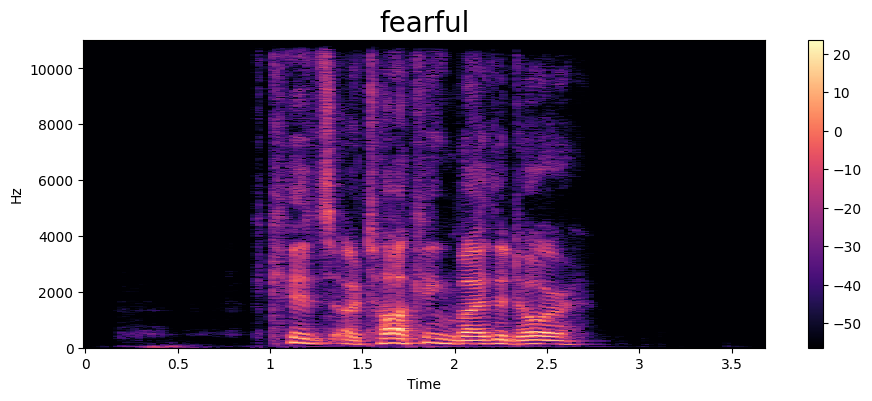

In [8]:
emotion = 'fearful'
path = np.array(ravdess['speech'][ravdess['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [9]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [10]:
extract_mfcc(ravdess['speech'][0])

array([-6.7019543e+02,  6.5063850e+01,  8.8895434e-01,  1.4715979e+01,
        9.1821651e+00,  6.6057485e-01, -3.8468359e+00, -3.5839462e+00,
       -1.2959006e+01, -3.3001330e+00,  9.1077960e-01, -3.5970356e+00,
        2.3762746e+00, -4.3889413e+00,  5.4508030e-01,  8.9185178e-01,
       -4.8025899e+00, -2.1054137e+00, -1.6059692e+00, -1.0523903e+00,
       -7.0672808e+00, -6.2306100e-01, -2.7280297e+00, -5.3073611e+00,
       -1.9691168e+00, -9.4615275e-01, -5.7211108e+00,  3.3299121e-01,
       -2.5438452e+00,  1.8220846e-01, -2.3510973e+00, -2.5047269e+00,
       -3.1515071e+00, -2.1908989e+00, -3.8017597e+00, -1.8130877e+00,
       -1.2612224e+00, -2.1449544e+00, -4.1521730e+00, -1.7796154e+00],
      dtype=float32)

In [11]:
print(ravdess.shape)

(1440, 2)


In [12]:
X_mfcc = ravdess['speech'].apply(lambda x: extract_mfcc(x))

In [13]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(1440, 40)

In [14]:
## input split
X.shape

(1440, 40)

In [15]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(ravdess[['label']])

In [16]:
y = y.toarray()

In [17]:
y.shape

(1440, 8)

In [18]:
enc.categories_

[array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
        'surprised'], dtype=object)]

In [19]:
# LSTM Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

model = Sequential([
    Dense(64, input_shape=(40,), activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,968 (19.41 KB)

 Trainable params: 4,968 (19.41 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history = model.fit(X_train, y_train, epochs=300, batch_size=64, validation_data=(X_test, y_test))
# history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1486 - loss: 85.3380 - val_accuracy: 0.1285 - val_loss: 20.0477
Epoch 2/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1366 - loss: 43.0821 - val_accuracy: 0.1424 - val_loss: 10.3242
Epoch 3/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1361 - loss: 26.5295 - val_accuracy: 0.1875 - val_loss: 5.4901
Epoch 4/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1201 - loss: 16.3530 - val_accuracy: 0.1736 - val_loss: 2.1686
Epoch 5/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1294 - loss: 9.0084 - val_accuracy: 0.1528 - val_loss: 2.0850
Epoch 6/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1260 - loss: 5.2057 - val_accuracy: 0.1597 - val_loss: 2.0763
Epoch 7/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1382 - loss: 3.9756 - val_accuracy: 0.1597 - val_loss: 2.0753
Epoch 8/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1459 - loss: 3.4317 - val_accuracy: 0.15

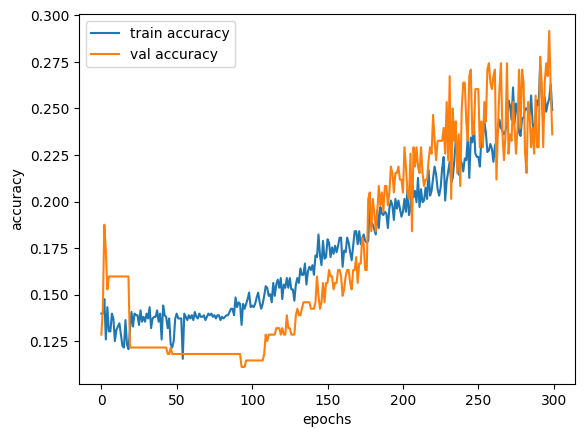

In [27]:
epochs = list(range(len(history.history['accuracy'])))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

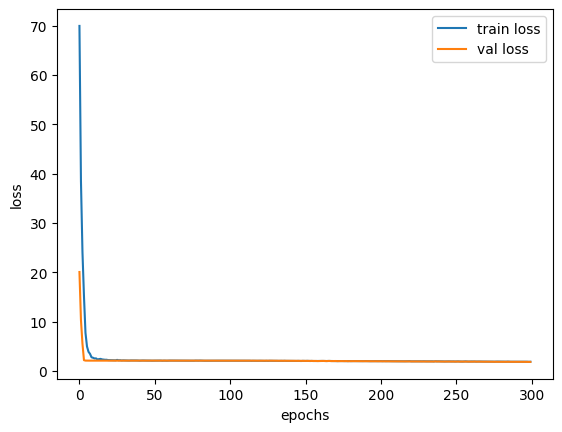

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [29]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

accuracy_score(y_true, y_pred), cm

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


(0.2361111111111111,
 array([[16,  7,  0,  0, 20,  0,  3,  0],
        [ 0, 33,  0,  0,  0,  0,  1,  0],
        [ 5, 16,  1,  0,  5,  0,  8,  0],
        [ 3,  6,  0,  0, 23,  0,  6,  0],
        [ 7,  3,  0,  0, 14,  0, 13,  0],
        [ 0, 22,  0,  0,  2,  0,  2,  0],
        [ 1, 15,  0,  0, 12,  0,  4,  0],
        [ 0,  8,  0,  0,  9,  0, 23,  0]], dtype=int64))

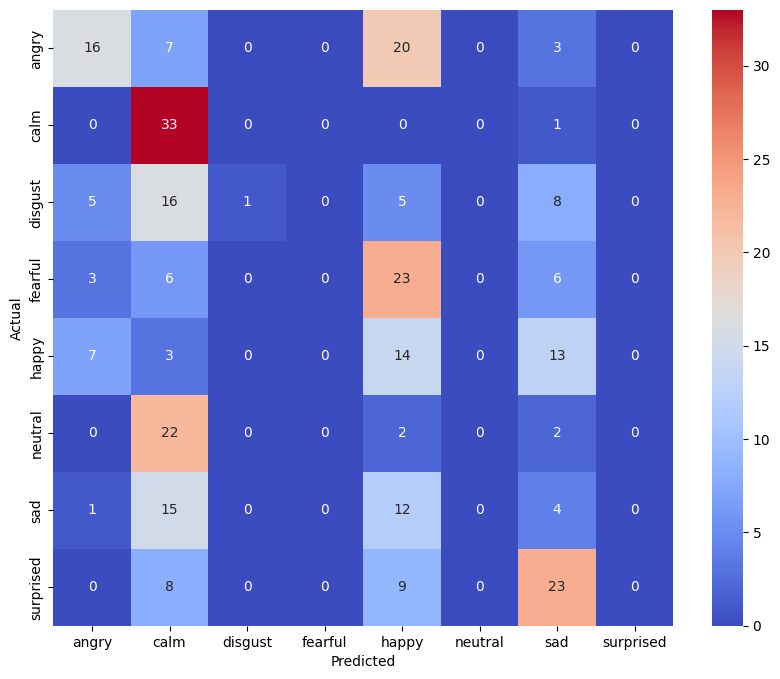

In [30]:
# print colorful confusion matrix
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


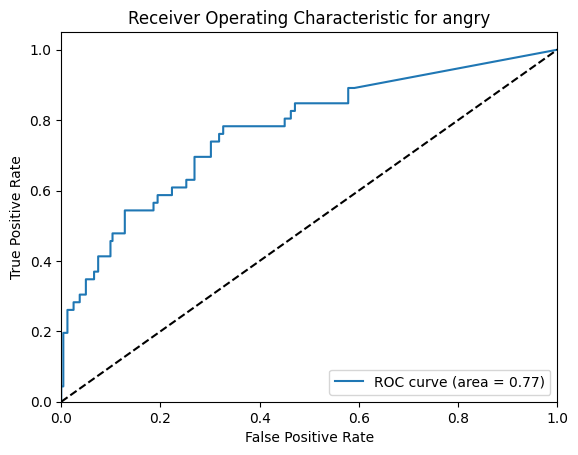

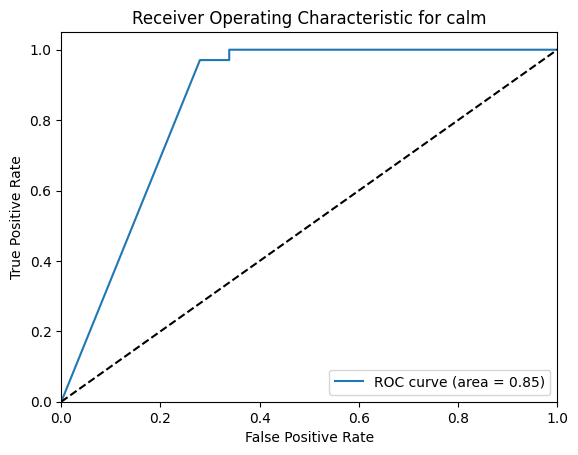

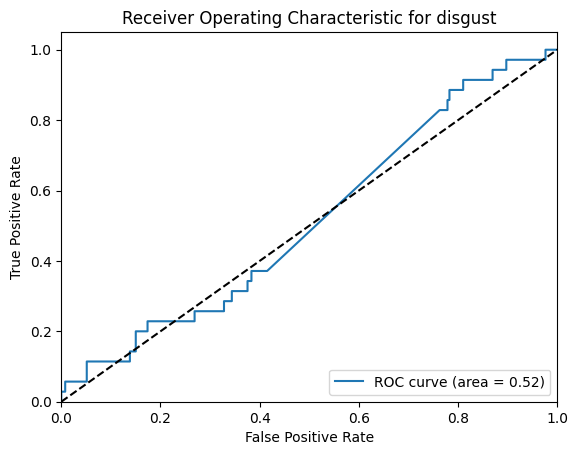

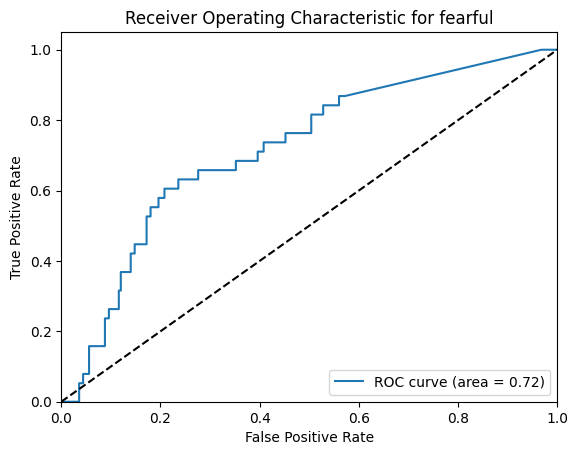

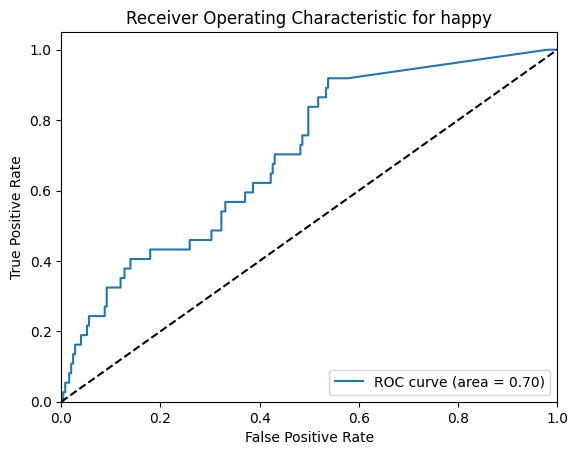

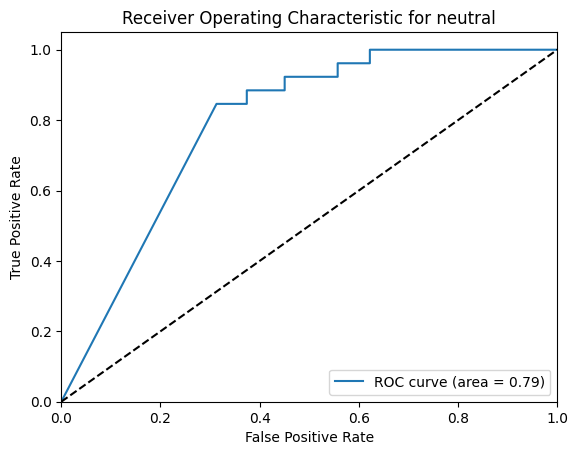

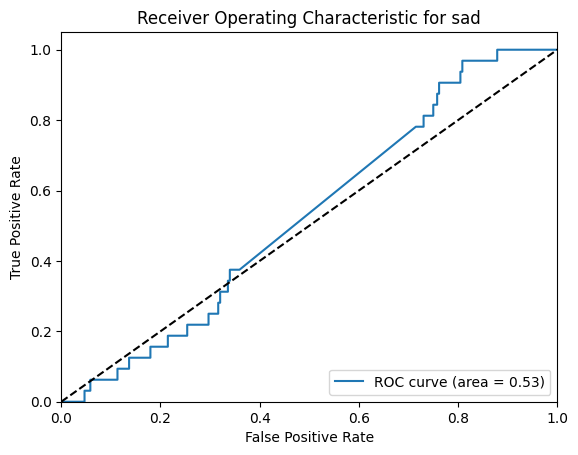

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

lb = LabelBinarizer()
y_test = lb.fit_transform(y_test)
y_pred = model.predict(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(7):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for '+enc.categories_[0][i])
    plt.legend(loc="lower right")
    plt.show()

In [26]:
# #save model
# model.save('..\Models\emotion_detection_mixed_MLP.keras')